In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install torch_audiomentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [4]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:
# other dependencies
#!pip install timm ipywidgets

In [6]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [8]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [9]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [10]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [11]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [12]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 32
test_batch_size = 32
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [13]:
def get_df_diff(df_super , df_sub):
    """This function performs data frame difference 
    - df_super is the super set 
    - df_sub is the subset
    At the end the function returns the "set theory difference "
    #https://stackoverflow.com/questions/18180763/set-difference-for-pandas
    """
    df_temp = pd.concat([df_super, df_sub, df_sub]).drop_duplicates(keep=False)
    df_temp.reset_index(inplace = True)
    df_temp.drop('index',axis = 1,inplace = True)
    df_temp.drop('level_0',axis = 1,inplace = True)
    return df_temp
    
    

In [14]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [80]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus','an coustani','ma uniformis','ma africanus' ]
# classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
#                'an coustani','ma uniformis','ma africanus' ]
#other_ind = classes.index('others')

In [81]:
len(classes)

8

### Read CSV and get train/test groups

In [16]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [17]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [18]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [19]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

In [20]:
len(df)

3476

In [21]:
#extracting the TZ and Cup data on which test should happen
#Test should happen on Cup and Tanzania

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [22]:
df_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


As a result of extraction ,"df_tz_cup" and "DF" doesn't have indices in sequence, let's reset.

In [23]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,208655,2.560000,2020-11-26_22.00.13.793.wav,8000,26-11-20 22:00,mosquito,an arabiensis,NaN,NaN,NaN,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3472,208623,2.560000,2020-11-26_22.00.13.793.wav,8000,26-11-20 22:00,mosquito,an arabiensis,NaN,NaN,NaN,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3473,208713,2.560000,2020-11-27_04.30.13.788.wav,8000,27-11-20 04:30,mosquito,an arabiensis,NaN,NaN,NaN,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3474,208712,2.560000,2020-11-27_04.30.13.788.wav,8000,27-11-20 04:30,mosquito,an arabiensis,NaN,NaN,NaN,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0


In [24]:
df_tz_cup.head()

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


### performing a "set difference" df - df_tz_cup

In [25]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_no_tz_cup = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)
#df_temp = get_df_diff(df , df_tz_cup)


In [26]:
df_no_tz_cup

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,7085,208655,2.560000,2020-11-26_22.00.13.793.wav,8000,26-11-20 22:00,mosquito,an arabiensis,NaN,NaN,...,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3472,7086,208623,2.560000,2020-11-26_22.00.13.793.wav,8000,26-11-20 22:00,mosquito,an arabiensis,NaN,NaN,...,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3473,7087,208713,2.560000,2020-11-27_04.30.13.788.wav,8000,27-11-20 04:30,mosquito,an arabiensis,NaN,NaN,...,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0
3474,7088,208712,2.560000,2020-11-27_04.30.13.788.wav,8000,27-11-20 04:30,mosquito,an arabiensis,NaN,NaN,...,NaN,HBN,phone,itel A16,Tanzania,Kilombero District,Morogoro,Ifakara,field,0


Verifying that the temp data does not have any test leakage

In [27]:
pd.merge(df_tz_cup,df_no_tz_cup, on = 'id',how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [28]:
df_no_tz_cup.reset_index(inplace = True)
df_no_tz_cup.drop('index',axis = 1,inplace = True)
df_no_tz_cup.drop('level_0',axis = 1,inplace = True)

In [29]:
df_no_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2


#### AT this stage "df_no_tz_cup" has no TZ and "Cup" Data . Let's verify from the length

In [30]:
print("len of df_temp = " + str(len(df_no_tz_cup)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_no_tz_cup)):
    print("split successful")
else:
    print("split error")

len of df_temp = 1188
len of df_tz_cup = 2288
len of df = 3476
split successful


### Before we start training we need to also have some samples from tz_cup in training.
we'll extract 80% of TZ cup samples randomly for this purpose

In [31]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 1830


### Again performing a "set-difference" so that:
* The final test set is a difference of entire TZ data and the ones that are sampled for the purpose of training

In [32]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [33]:
df_test
df_test.reset_index(inplace= True)

In [34]:
df_test.drop('index',axis = 1)

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,4,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,16,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,17,221139,5.12,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,19,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,2269,222594,48.58,IFA_86_24_3424.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
454,2270,222620,30.72,IFA_86_25_3425.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
455,2272,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
456,2282,222618,35.84,IFA_86_38_3438.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,t,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


Add some TZ_cup sampled to the Training data

In [35]:
df_test.drop('index',axis = 1,inplace = True)
df_test.drop('level_0',axis = 1,inplace = True)

In [36]:
df_test

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,221139,5.12,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,222594,48.58,IFA_86_24_3424.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
454,222620,30.72,IFA_86_25_3425.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
455,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
456,222618,35.84,IFA_86_38_3438.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,t,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


We now concatenate the data extracted from TZ samples and the "DF_No_TZ_CUP" that was obtained after removing TZ and cup samples

In [37]:
temp_train_frame = [df_no_tz_cup , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 3018


Let's now extract rows from this "Temp_frame" to get our val data


In [38]:
#df_tz_cup.sample(frac = .8 , random_state = 42)
idx_multiclass_val = np.logical_and(df_temp_train['country'] == 'Tanzania', df_temp_train['location_type'] == 'cup')
df_val = (df_temp_train[idx_multiclass_val]).sample(frac = .22 , random_state= 42)
df_val


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
1449,221684,10.24,IFA_57_16_2256.wav,44100,28-06-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3568.0
1386,221580,7.62,IFA_55_31_2191.wav,44100,23-06-20 00:00,mosquito,culex pipiens complex,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,3501.0
739,220123,10.24,IFA_37_24_1464.wav,44100,04-03-20 00:00,mosquito,an arabiensis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2727.0
722,220165,17.92,IFA_37_10_1450.wav,44100,04-03-20 00:00,mosquito,an funestus ss,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,2709.0
126,220542,2.56,IFA_21_27_827.wav,44100,08-02-20 00:00,mosquito,an arabiensis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,221620,2.56,IFA_56_24_2224.wav,44100,23-06-20 00:00,mosquito,an funestus ss,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,3531.0
1083,221302,2.56,IFA_47_16_1856.wav,44100,27-03-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3134.0
332,220776,25.54,IFA_27_11_1051.wav,44100,12-02-20 00:00,mosquito,ma uniformis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,6,2255.0
1319,221497,25.60,IFA_54_13_2133.wav,44100,22-06-20 00:00,mosquito,an arabiensis,Male,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3430.0


In [39]:
df_temp_train.reset_index(inplace = True)

In [40]:
df_val.reset_index(inplace = True)

### Now peforming a "set difference" on temp_train and df-val 

In [41]:
from sklearn.model_selection import train_test_split
# avoiding train test split and using the same logic as in original Humbug paper
# train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
#test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]
# #df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# msk = np.random.rand(len(df_temp_train)) < 0.8
# df_train = df_temp_train[msk]
# df_val_temp  = df_temp_train[~msk]
df_train = pd.concat([df_temp_train, df_val, df_val]).drop_duplicates(keep=False)


In [42]:
pd.merge(df_train,df_val , on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [43]:
df_train

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
0,0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
1,1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
2,2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
3,3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
4,4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,761,220212,2.560000,IFA_38_14_1494.wav,44100,07-03-20 00:00,mosquito,an arabiensis,Female,f,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2753.0
3013,1246,221400,2.560000,IFA_52_11_2051.wav,44100,21-06-20 00:00,mosquito,an arabiensis,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3341.0
3014,1203,221477,23.040000,IFA_50_32_1992.wav,44100,17-06-20 00:00,mosquito,culex pipiens complex,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,3288.0
3015,1878,222082,2.560000,IFA_67_14_2654.wav,44100,14-07-20 00:00,mosquito,an funestus ss,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,4025.0


In [44]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 2615
length of val = 403


Let's verify if any of the test recording has leaked into train or val

In [45]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [46]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [47]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [48]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [49]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 69881
length of test offset = 21043
length of val offset = 17637


In [50]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [51]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [52]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [53]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [54]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.28499592 0.59454975 4.67118984 0.6563815  2.29932219 5.11723784
 3.64875731 5.97886721]


In [55]:
len(df_val_offset)

17637

In [56]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
30650
DF type = train
i = 1
14692
DF type = train
i = 2
1870
DF type = train
i = 3
13308
DF type = train
i = 4
3799
DF type = train
i = 5
1707
DF type = train
i = 6
2394
DF type = train
i = 7
1461


In [57]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
8248
DF type = Val
i = 1
3307
DF type = Val
i = 2
566
DF type = Val
i = 3
2920
DF type = Val
i = 4
1089
DF type = Val
i = 5
601
DF type = Val
i = 6
737
DF type = Val
i = 7
169


In [58]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
8159
DF type = test
i = 1
4107
DF type = test
i = 2
1182
DF type = test
i = 3
4558
DF type = test
i = 4
772
DF type = test
i = 5
689
DF type = test
i = 6
1230
DF type = test
i = 7
346


In [59]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [60]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [61]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [62]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [63]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [64]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [65]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2


In [66]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [67]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 500 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            #plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            overrun_counter = -1
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [68]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [69]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=apply_augmentation):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        if idx%2 == 0:
            if DEBUG:
                print("shape of x = " + str(x.shape))
                print("applying augmentations...")
            #augmentation expect input in the form of [bat,chann,sample]
            x_unsq = x.unsqueeze(dim = 1)
            if DEBUG:
                print("shape of x_unsq = " + str(x_unsq.shape))
            x = apply_augmentation(x_unsq, sample_rate=config.rate)
            x = x.squeeze(dim = 1)
            if DEBUG:
                print("shape of x post augmentation = " + str(x.shape))
            
                       
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [70]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [71]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [72]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [73]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [74]:
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = apply_augmentation)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [75]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 69881
Length of train loader = 2184


In [76]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [77]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [78]:
def load_model(filepath, model=Model('convnext_small',224)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0796 seconds


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0769 seconds
Training on cuda:0


  0%|          | 0/2184 [00:00<?, ?it/s]

epoch = 0batch = 0 of 2184duraation = 0.01751394271850586
epoch = 0batch = 500 of 2184duraation = 3.1108484506607055
epoch = 0batch = 1000 of 2184duraation = 6.193832731246948
epoch = 0batch = 1500 of 2184duraation = 9.277781891822816
epoch = 0batch = 2000 of 2184duraation = 12.370954271157583
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_19_20_47_45.pth
Epoch: 0, Train Loss: 1.71132135, Train f1: 0.40827250, Val Loss: 0.00253161, Val f1: 0.39499238, overrun_counter 0
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.73      0.31      0.44      8159
culex pipiens complex       0.38      0.44      0.41      4107
           ae aegypti       0.30      0.22      0.25      1182
       an funestus ss       0.56      0.43      0.49      4558
         an squamosus       0.11      0.34      0.16       772
          an coustani       0.18      0.81      0.30       689


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (8).

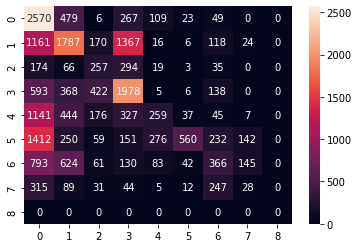

In [79]:
model =Model('convnext_small',224)
#filepath = "../outputs/models/pytorch/model_e12_2022_09_19_03_13_34.pth"
#model_epcoh_11 = load_model(filepath,model)
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))